# Simple Binary Classification of Lightning Strike Images

This notebook illustrates the process of building a classification system, which is used to classify images regarding containing a lightning strike or not.<br>The goal is to build the classification system by training a *simple* maschine learning model. <br>Using maschine learning to solve a particular problem usually involves three steps:

1) *Data wrangling*: Maschine Learning works on the basis of data. The basic premise of a classification system is simple: A maschine attempts to "learn" the (possibly hidden) relationship between the input data, in this case the images, and the expected results, aka whether or not the image contains a lightning strike.<br> This obviously requires a dataset, containing many images of lightnings and landscapes without the latter in different forms and settings, so that there is enough data from which the algorithem can etract meaningful insights and relations.<br>For this case, the undelying dataset is made of ~200 images, 2/3 of which containing lightnings and the rest being landscapes with a cloudy, stormy sky.<br>

2) *feature engineering*: A possible solution to the problem would be of course to just feed the learning/fitting algorithm with the raw image data, which would essentially be a vector with as many dimensions as pixles in the image. But this would be a bad decision for a multitude of reasons. The most prominent being that a high dimensionality of the feature vector promotes *model overfitting*. This means, that the model can possibly perform really well on the data it has used to learn, but when using it on previously unseen data, it would perform really badly, because it might have learned the *wrong relationships* and is too specialized on the training dataset.<br> Thus it is necessary to first engineer meaningful porperties about the images, which can then be used as *more fitting representations* of the images for the purpose of machine learning.

3) *model building*: In the last step, with all the images being reduced down to their corresponding feature vectors and ready to go, it is all about choosing the best actual machine learning algorithm and to possibly optimze its *hyperparameters*.<br>There are multiple different algorithms for the task of classification and some might work better than others in different situations. For example there might be choices, that do better on particularily small datasets such as in this case or others, that do better with hughe datasets, because they run faster.<br> Then there is hyperparameter optimization: Any of there algorithms also have parameter, that dictate the exact way they run. (...)

## The setup

This notebook will make use of various third party python libraries for image processing and maschine learning methods. 

In [1]:
# Importing of standard library modules
import math
import os
import pickle
import copy

# Importing of third party libreries
from IPython.display import display, display_pretty, HTML
import matplotlib.pyplot as plt
import imageio
import pandas as pd
import numpy as np
import cv2 

from skimage import filters
from skimage.measure import regionprops

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.externals import joblib

from mahotas.features import surf
import mahotas as mh

import keras

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# NOTEBOOK WIDE SETTINGS

# This will adjust the width of all the notebook output cells to span over the full width of the notebook
display(HTML("<style>.container { width:100% !important; }</style>"))


## Feature engineering

This section is about the ideas behind all the features, that are being extracted from the image.

To put it simply: Features of images are at their core values, that have been calculated in some way from the image's raw data. Feature engineering is an important aspect of the machine learning process, because the quality of the outcome of the classification task strongly depends on how well the features are able to determine the result.

For example we as humans want to classify whether or not a person we meet is friendly or mean, to determine if we should approach and talk to that person. Now imagine you have had bad experiences with, let's say, accountants in the past (this is the learning process) and now you will instantly have a bad feealing about someone, once you fing out that this person is an accountant. In this example your "feature" for classifying humans would be whether their profession is accounting or not. Your brain didnt score the person as a whole, with all pros and cons, because that would take too much time, instead it reduces people into a set of *derived* features.

This illustrates, why the correct features are so important: Objectively, being an accountant might not be a good meassure for friendliness at all, at least less so than the frequency of smiles for example.

In [5]:
# FEATURE ENGINEERING

# Here we will load the two pictures, to be compared to each other feature-wise.
# The paths to the two files to be loaded
folder_path = '/home/jonas/Nextcloud/Programmieren/PyCharm/aragats/ml/clean'
lightning_path = os.path.join(folder_path, '0035.jpg')
normal_path = os.path.join(folder_path, '0021.jpg')

# We will need both the colored version as well as the grayscale version of the image, because 
# although most of the features are extracted from the gray scale, a few are based on the color channels
lightning_image_color = cv2.imread(lightning_path)
lightning_image_blue, lightning_image_green, lightning_image_red = cv2.split(lightning_image_color)
# The "L" mode means, that the image gets loaded in gray scale mode
lightning_image_gray = imageio.imread(lightning_path, pilmode='L')

normal_image_color = cv2.imread(normal_path)
normal_image_blue, normal_image_green, normal_image_red = cv2.split(normal_image_color)

normal_image_gray = imageio.imread(normal_path, pilmode='L')

# DEFINING BASIC IMAGE PROPERTIES
width = lightning_image_gray.shape[0]
height = lightning_image_gray.shape[1]
area = width * height


In [6]:
# BASIC STATISTICAL VALUES (mean, max)

# The overall highest intensity value in the whole image
lightning_max = np.max(lightning_image_gray)
normal_max = np.max(normal_image_gray)

# The average intensity of the whole image
lightning_mean = np.mean(lightning_image_gray)
normal_mean = np.mean(normal_image_gray)

# Displaying them in a pandas dataframe
_list = [
    {
        'max':  lightning_max,
        'mean': lightning_mean
    },
    {
        'max':  normal_max,
        'mean': normal_mean
    }
]
basic_statistical_dataframe = pd.DataFrame(_list)
display_pretty(basic_statistical_dataframe)


   max        mean
0  255   81.610104
1  152  105.525490

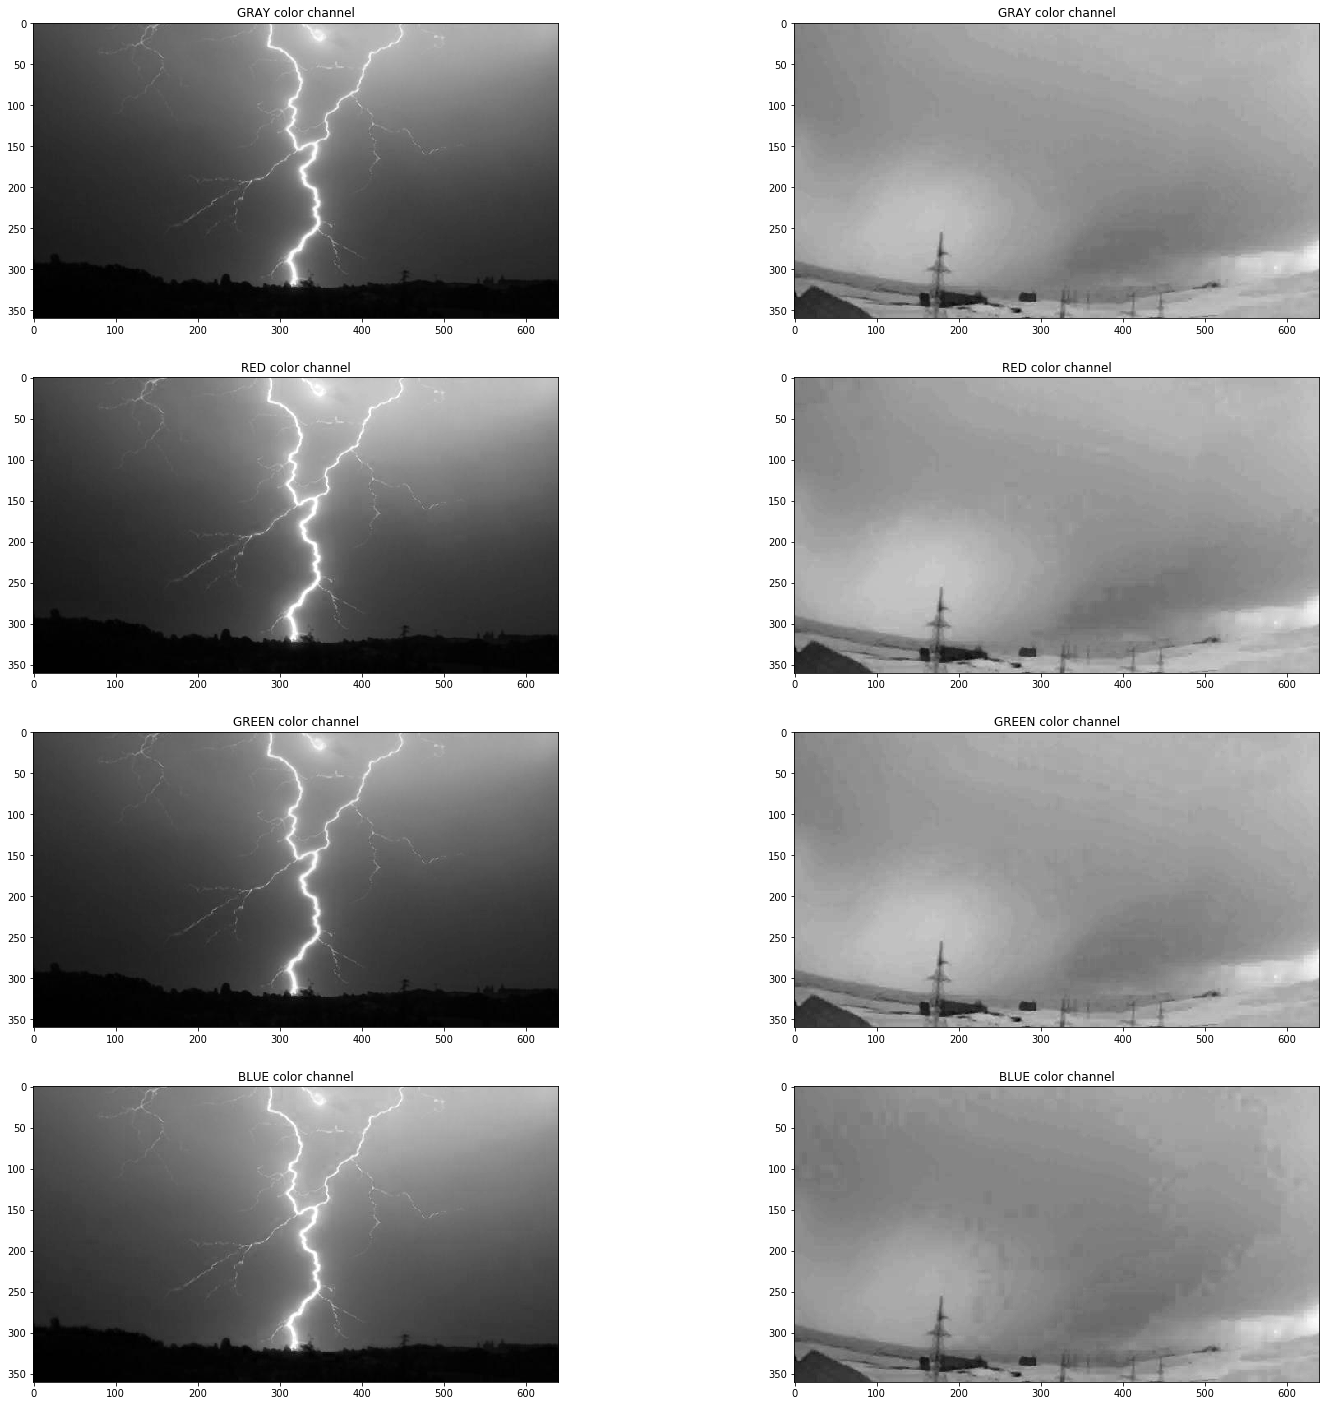

In [7]:
# DISPLAYING THE TWO IMAGES AND THEIR COLOR CHANNELS

fig = plt.figure(figsize=(25, 25))

# Displaying all the images for the lightning image
lightning_images_dict = {
    'gray':         lightning_image_gray,
    'red':          lightning_image_red,
    'green':        lightning_image_green,
    'blue':         lightning_image_blue
}
for name, image, index in zip(lightning_images_dict.keys(), lightning_images_dict.values(), range(1, 8, 2)):
    ax = fig.add_subplot(4, 2, index)
    ax.imshow(image, cmap='gray')
    ax.set_title('{} color channel'.format(name.upper()))

# Displaying the images for the normal image
normal_images_dict = {
    'gray':         normal_image_gray,
    'red':          normal_image_red,
    'green':        normal_image_green,
    'blue':         normal_image_blue
}
for name, image, index in zip(normal_images_dict.keys(), normal_images_dict.values(), range(2, 9, 2)):
    ax = fig.add_subplot(4, 2, index)
    ax.imshow(image, cmap='gray')
    ax.set_title('{} color channel'.format(name.upper()))


### blue lightnings?

The previous section displayed the intensity values for the different color channels of the two sample images. This shows, that the lightning appears significantly brighter in the blue channel.

This leads to the assumption, that one of the "features" of a lightning image might be a higher count of pixels with high intensities in the blue color channel.<br> The high blue factor divides the amount of pixels above a certain intensity in the blue channel of the picture by the amount of pixels in the same intensity range in the resulting grayscale image.

In [8]:
# Calculating the high blue factor
def high_blue(image_gray, image_blue, threshold=180):
    # Counting how many pixles are above the given intensity value for the gray scale 
    # and the blue channel
    gray_count = np.sum(image_gray > threshold)
    blue_count = np.sum(image_blue > threshold)
    
    # There We only need to see the special case of the gray scale count being zero 
    # because this would cause a zero division.
    # that case means that the image doesnt contain gray scale values above the 
    # threshold at all, which in turn means its probably not a lightning. 
    if gray_count == 0:
        return 0
    else:
        return blue_count / gray_count


high_blue_lightning = high_blue(lightning_image_gray, lightning_image_blue)
high_blue_normal = high_blue(normal_image_gray, normal_image_blue)

display('High blue factors for the two images: lightning {}, normal {}'.format(
    high_blue_lightning,
    high_blue_normal
))


'High blue factors for the two images: lightning 2.2618284395435313, normal 0'

### Histogram Binning

The technique, called *histogram binning* is pretty popular with image classification. An image histogram shows how many pixels have a certain intensity value. These pixel counts can be directly used as features: "How many pixels have the intensity 1, 2, 3 ... n?". So for each image there would be 255 features to represent an aspect about the image.<br>
The issue is that when using this for the grayscale image and all three color channels independantly, this would create over 1000 features for each image. To reduce this number, the process of *binning* is often used. The idea is to not use the count for every pixel value separatly, but to use counts for *ranges* of intensity values. So instead of "How many pixels have the value 139?", it could be "How many pixels have a value in the range between 0 and 20?".

The following code defines a function to create a dictioniary with n features from the image, that is based on the pixel counts of n equal ranges along the histogram of the images.

In [9]:
# HISTOGRAM BINNING


def histogram_n_bins(image, n=10, name='image'):
    bins = np.histogram(image, n, (0, 255))[0]
    features = {}
    for value, index in zip(bins, range(0, n)):
        features['{} bin {}'.format(name, index)] = value
    return features

# Displaying the histograms for the images.
bins_lightning = np.histogram(lightning_image_gray, 10, range=(0, 255))


'Using the "11520" pixels with the highest value, that is 5.0%'

'The mean across the highest pixels: lightning 9.748736979166667, normal 6.231228298611111'

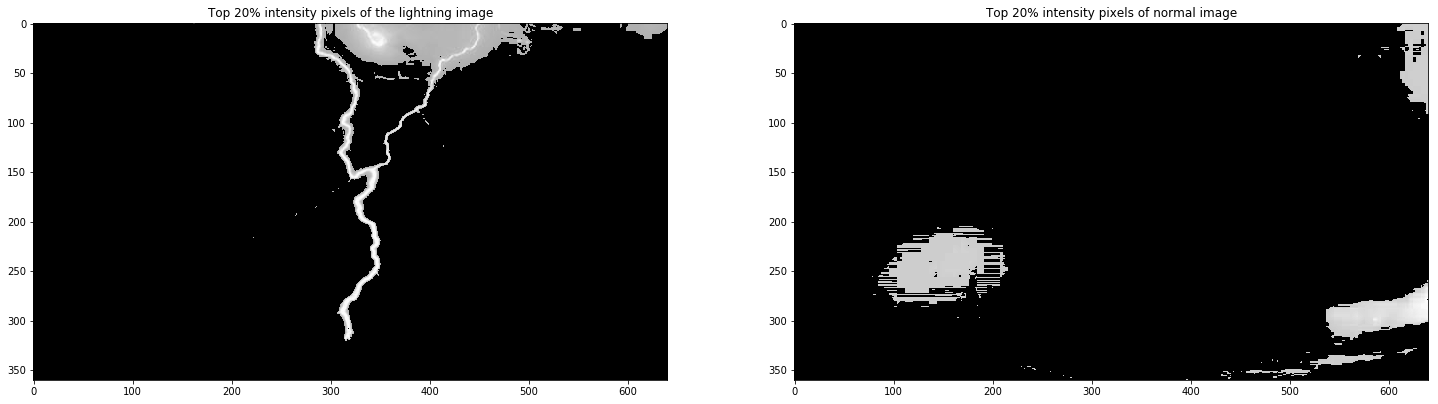

In [10]:
# Calculating the mean value of the top n pixels
top_percentage = 0.05
n = int(top_percentage * area)
display('Using the "{}" pixels with the highest value, that is {}%'.format(n, top_percentage * 100))


def n_top_values(array, n):
    array_copy = np.copy(array)
    array_copy[0, 0] = 0
    array_flattened = array_copy.flatten()
    index_array = array_flattened.argsort()
    index_array[:-n] = 0
    index_array_aligned = np.zeros(index_array.shape, dtype=index_array.dtype)
    for i in range(-(n+1), -1, 1):
        value = index_array[i]
        index_array_aligned[value] = value
    array_result = array_flattened[index_array_aligned]
    array_result = array_result.reshape((array.shape[0], array.shape[1]))
    return array_result


# We create a new image (copy of the old one), which only uses the n brightest 
# pixels of the original image. And we will calculate the mean of that.
lightning_image_top = n_top_values(lightning_image_gray, n)
normal_image_top = n_top_values(normal_image_gray, n)

# Displaying the resulting images
fig = plt.figure(figsize=(25, 25))

ax_lightning = fig.add_subplot(1, 2, 1)
ax_lightning.imshow(lightning_image_top, cmap='gray')
ax_lightning.set_title('Top 20% intensity pixels of the lightning image')

ax_normal = fig.add_subplot(1, 2, 2)
ax_normal.imshow(normal_image_top, cmap='gray')
ax_normal.set_title('Top 20% intensity pixels of normal image')

# Calculating the mean over those highest values
lightning_mean_top = np.mean(lightning_image_top)
normal_mean_top = np.mean(normal_image_top)
display('The mean across the highest pixels: lightning {}, normal {}'.format(
    lightning_mean_top,
    normal_mean_top
))


In [11]:

# CALCULATING THE VARIANCE COEFFICIENTS

region_properties_lightning_top = regionprops((lightning_image_top > 1).astype(int), lightning_image_top)[0]
moments_lightning = region_properties_lightning_top.weighted_moments_normalized
x_variance_lightning = moments_lightning[2, 0]
y_variance_lightning = moments_lightning[0, 2]

region_properties_normal_top = regionprops((normal_image_top > 1).astype(int), normal_image_top)[0]
moments_normal = region_properties_normal_top.weighted_moments_normalized
x_variance_normal = moments_normal[2, 0]
y_variance_normal = moments_normal[0, 2]

display('The lightning image has the variance coefficients x: {}, y: {}'.format(
    x_variance_lightning,
    y_variance_lightning
))
display('The normal image has the variance coefficients x: {}, y: {}'.format(
    x_variance_normal,
    y_variance_normal
))


'The lightning image has the variance coefficients x: 0.0029453199553672953, y: 0.002268254459169563'

'The normal image has the variance coefficients x: 0.005732793880259631, y: 0.03533918964476912'

### SURF Feature Descriptors

The SURF (Speeded up robust features) algorithm aims to provide local feature descriptors for images. In its base form the algorithm therefore first searches the images for points of interest and then commputing a local descriptor for each of these points, which describes the intensity distribution of the pixels around the point. To illustrate this, in the section below will show the two sample images, with the surf descriptors plotted as overlaying red boxes.

#### SURF descriptor count

Using these descriptors for the machine learning model however is difficult, because the amount of descriptors varies depending on how many points of interest have been found in the first stage.

To solve this porblem, the "dense" function of the surf module is used. This function skips the process of detecting points of interest and just computes a surf descriptors in a regular grid pattern along the whole picture. Given the images are all the same size, this will result in the same number of descriptors every time.

#### SURF descriptor schape

Another problem arises from the shape of these descriptors. There was a lot of talk about these "descriptors" now, but what actually are they?<br>When it comes down to it they are jsut a bunch of numbers. As the following section will show, a surf descriptor form the dense function will be an array of 64 values.<br>The question is: How do we use those for the machine learning task? These 1404 arrays of 64 values each will have to be turned into useful features somehow.<br>Sure, a posibility would be to just use every single value as a feature and thus introduce 1404 * 64 new features to every image, but that sounds just as bad as putting int the whole image raw...

'The amount of surf descriptors for the lightning image 48'

'The amount of surf descriptors for the normal image 37'

'amount og dense surf descriptors 1404'

'shape of a dense surf descriptor (64,)'

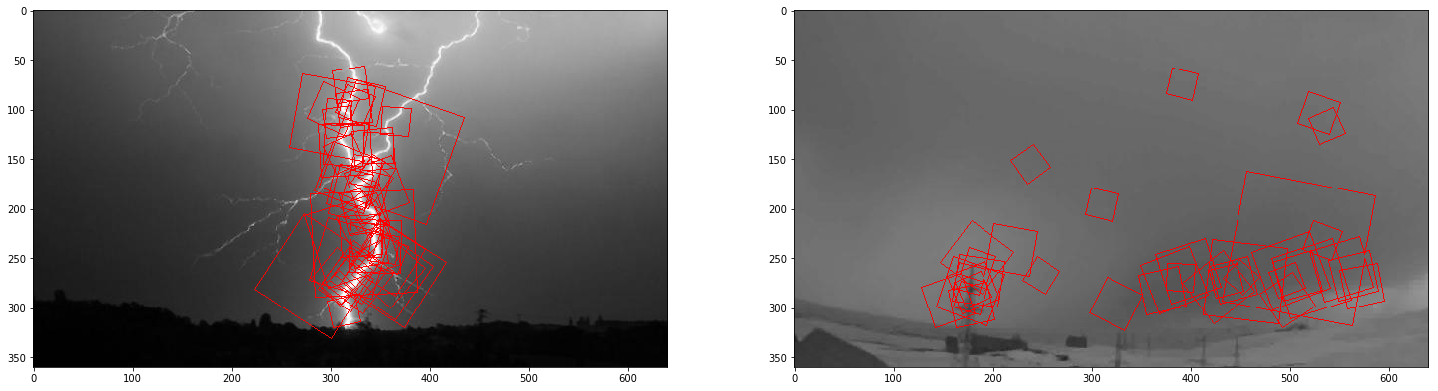

In [12]:
# SURF FEATURE EXTRACTION

surf_parameters = {
    'nr_octaves':           8,
    'nr_scales':            16,
    'initial_step_size':    1,
    'threshold':            0.1,
    'max_points':           50
}

surf_lightning = surf.surf(lightning_image_gray, **surf_parameters)
surf_normal = surf.surf(normal_image_gray, **surf_parameters)

surf_dense_lightning = surf.dense(lightning_image_gray, spacing=10)
surf_dense_normal = surf.dense(normal_image_gray, spacing=10)

# Showing the surf descriptors on the images
fig_surf = plt.figure(figsize=(25, 25))

ax_lightning_surf = fig_surf.add_subplot(1, 2, 1)
ax_lightning_surf.imshow(surf.show_surf(lightning_image_gray, surf_lightning))

ax_normal_surf = fig_surf.add_subplot(1, 2, 2)
ax_normal_surf.imshow(surf.show_surf(normal_image_gray, surf_normal))

display('The amount of surf descriptors for the lightning image {}'.format(len(surf_lightning)))
display('The amount of surf descriptors for the normal image {}'.format(len(surf_normal)))

display('amount og dense surf descriptors {}'.format(len(surf_dense_lightning)))
display('shape of a dense surf descriptor {}'.format(surf_dense_lightning[0].shape))

### SURF visual bag of words

A more sophisticated method would be to use these descriptors to build a *visual bag of words model*

#### Visual bag of words (VBOW)

But what is a *visual bag of words* even? Imagine this: For a given classification task we would have to classify if an image displays a forest or a building. For this we define a set of *visual words*, those are small sections of an image, that have a special meaning. We look at the picture of a building for example as being a whole sentence. This sentence is made out of smaller parts, the individual words, that occur possibly multiple times in different contexts. For a building the words would be windows, doors or walls. A forest on the other hand is made up of trees, flowers, bushes and many more. But for this task our defined set of visual words would only inlcludes a flower and window. Now you can probably guess, that a classification of building versus forest can be pretty simple by just watching out for which one has more windows/flowers, as forests dont tend to have windows and buildings are usuallly not littered with flowers.

This means the local surf descriptors can be seen as breaking an image down into its smaller sections, it's *words*

#### SURF VBOW

Now there is still a problem: With the surf descriptors we might have the words for every image, but nothing to compare them to. It is not defined how the "flower" or "window" of lightning classification looks like and doing this manually isnt the best option either. Instead unsupervised machine learning in the form of clustering will be used to do just that.

To break it down, here is whats going to happen: In a *preprocessing step*, before any of the *real classification learning* there needs to be an additional step: The surf descriptors of all images are calculated and used as the basis for *clustering*. The idea is, that an algorithm tries its best to divide the whole dataset into *K* clusters of similiar descriptors. We can imagine, that each of these clusters contains some *type of visual word*. For example the one cluster contains descriptors for clouds and the other for parts of a lightning and so on. This clustering model will now be the reference point to compare the individual descriptors to.

Now back in the *actual learning process* this *pre trained clustering* model can be used to determine how many descriptors of any given image belong to which cluster (type of visual word). The result is a count for each cluster. Basically this will be a meassure very similiar to "how many flowers does this image contain", "how many windows does it contain", the only difference being, that it is unknown what kind of word it actually is.

In [13]:

def train_surf_vbow(image_paths, model_save_path, k=20):
    surfs = []
    for image_path in image_paths:
        # Loading the picture
        image = imageio.imread(image_path, pilmode='L')
        # extract the surf vector
        surf_image = surf.dense(image, spacing=10)
        surfs.append(surf_image)
    
    # Having all the surf vectors in a list 
    # making that into an array
    surfs_array = np.array(surfs)
    
    # Create a model and train it.
    k_means_args = {
        'n_init':       10,
        'max_iter':     100,
        'n_jobs':       -1,
        'verbose':      0
    }
    k_means = KMeans(k, **k_means_args)
    k_means.fit(np.concatenate(surfs_array))
    
    # Save model
    joblib.dump(k_means, model_save_path)
        
    return k_means

def extract_surf_vector(cluster_model, image, k=20):
    # Extracting the surf vectors from the image
    surf_image = surf.dense(image, spacing=10)
    
    labels = cluster_model.predict(surf_image)
    vbow = np.bincount(labels, minlength=k)
    features = {}
    for value, index in zip(vbow, range(0, k)):
        features['surf bin {}'.format(index)] = value
    return features

# Training the cluster model for the surf descriptors

k_means_save_path = os.path.join(folder_path, 'surf_cluster.pkl')
file_paths = []
for root, dirs, files in os.walk(folder_path):
    for file in sorted(files):
        if 'jpg' in file:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    break
# k_means = train_surf_vbow(file_paths, k_means_save_path)

k_means = joblib.load(k_means_save_path)
display(np.bincount(k_means.predict(surf.dense(lightning_image_gray, spacing=10)), minlength=20))
display(np.bincount(k_means.predict(surf.dense(normal_image_gray, spacing=10)), minlength=20))
display_pretty(extract_surf_vector(k_means, normal_image_gray))



array([ 56,   7,  40,  18,  29, 117,   1, 106, 585,  75,  13,   2,  42,
        78,  22,  97,  44,  26,  22,  24])

array([115,  47, 143,  27,  42, 131,   5, 170, 120,  22,  48,  36,  31,
        99, 122, 132,   4,  22,  50,  38])

{'surf bin 0': 115,
 'surf bin 1': 47,
 'surf bin 2': 143,
 'surf bin 3': 27,
 'surf bin 4': 42,
 'surf bin 5': 131,
 'surf bin 6': 5,
 'surf bin 7': 170,
 'surf bin 8': 120,
 'surf bin 9': 22,
 'surf bin 10': 48,
 'surf bin 11': 36,
 'surf bin 12': 31,
 'surf bin 13': 99,
 'surf bin 14': 122,
 'surf bin 15': 132,
 'surf bin 16': 4,
 'surf bin 17': 22,
 'surf bin 18': 50,
 'surf bin 19': 38}

In [14]:

def extract_features(image_path, blue_threshold=180, top_percent=0.05):
    # Loading the image in all color channels and gray scale value
    image_gray = imageio.imread(image_path, pilmode='L')
    image_color = cv2.imread(image_path)
    image_blue, image_green, image_red = cv2.split(image_color)
    area = image_gray.shape[0] * image_gray.shape[1]
    
    # Basic statistical info about the gray scale picture
    mean = np.mean(image_gray)
    top = np.max(image_gray)
    
    # High blue value
    high_blue_factor = high_blue(image_gray, image_blue, blue_threshold)
    
    # Creating the image, that only contain the top n intensity pixels
    n = int(area * top_percent)
    image_top = n_top_values(image_gray, n)
    
    # The mean value for the top pixels and the variance along the axes
    mean_top = np.mean(image_top)
    region_properties = regionprops((image_top > 1).astype(int), image_top)[0]
    x_variance = region_properties.weighted_moments_normalized[2, 0]
    y_variance = region_properties.weighted_moments_normalized[0, 2]
    
    features = {
        'max':          top,
        'mean':         mean,
        'mean_top':     mean_top,
        'high_blue':    high_blue_factor,
        'x_variance':   x_variance,
        'y_variance':   y_variance
    }
    
    # Extracting the surf features
    cluster_model_path = os.path.join(folder_path, 'surf_cluster.pkl')
    cluster_model = joblib.load(cluster_model_path)
    surf_features = extract_surf_vector(cluster_model, image_gray)
    
    features.update(surf_features)
    
    # Histogram binning
    features_histogram_blue = histogram_n_bins(image_blue, name='blue')
    features.update(features_histogram_blue)
    
    return features 


In [15]:
def feature_interactions(dataframe):
    poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    result = poly_features.fit_transform(dataframe)
    columns = list(dataframe.keys())
    names = []
    for row in poly_features.powers_:
        name_list = []
        for index in range(0, len(columns)):
            if row[index] != 0:
                name_list.append('{}^{}'.format(columns[index], row[index]))
        names.append(' x '.join(name_list))
    result_dataframe = pd.DataFrame(result, columns=names)
    return result_dataframe


In [16]:
# LOADING THE WHOLE DATASET
# First we load a list with all the file paths
file_paths = []
for root, dirs, files in os.walk(folder_path):
    for file in sorted(files):
        if 'jpg' in file:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    break
    
    
def extract_label(image_path):
    json_path = image_path.replace('jpg', 'json')
    if os.path.exists(json_path):
        value = 1
    else:
        value = 0
    return {'is_lightning': value}
    
    
# Then we use these file paths to generate the features for every image. The features are stored 
# as a list of dicts, which can then be directly converted into a pandas dataframe
feature_dicts = list(map(extract_features, file_paths))
label_dicts = list(map(extract_label, file_paths))
feature_dataframe = pd.DataFrame(feature_dicts)
display_pretty(feature_dataframe.head())

#feature_interactions_dataframe = feature_interactions(feature_dataframe)
#display_pretty(feature_interactions_dataframe.head())

#feature_dataframe = feature_interactions_dataframe

label_dataframe = pd.DataFrame(label_dicts)


   blue bin 0  blue bin 1  blue bin 2  blue bin 3  blue bin 4  blue bin 5  \
0         386       15687       28537       10466       42455       41926   
1           0         243        4170       50306      166233        9006   
2           0         240        4356       40546      171646       11559   
3       67954        6231        3591        5729       34515       45232   
4           0          83        3636        4470      123025       60224   

   blue bin 6  blue bin 7  blue bin 8  blue bin 9     ...      surf bin 2  \
0       57022       19772       12208        1941     ...              83   
1         442           0           0           0     ...             134   
2        1882         129          16          26     ...             124   
3       49289       15282        1904         673     ...              98   
4       20529        9917        4946        3570     ...              52   

   surf bin 3  surf bin 4  surf bin 5  surf bin 6  surf bin 7  surf bin 8 

## Feature Scaling

Normally features are a variety of different dimensions. For example if one feature might be the raw temperature in degrees celsuis, then value will never be above 1000 degrees for example. But another feature might be a counting variable, which could very well be above 100000 value-wise.

And for some algorithms, this can present a problem, because they might base their decision on how big the actual value is and if it is looking at two totally different scales, the outcome might not be very representative of what insights could actually be gained by those features.

Another example might be algorithms, such as the *feature selection* in the next section cant work with negative values.

All this makes it necessary to scale the features to one common scale. There are many possible scaling methods available, such as using a statistical scale, so that the distribution of values among one feature gets normalized with a speciifc standard deviation and expected value of 0, but here a simpler approach is used. All features are simply scaled to floeating point values in the range between 0 and 1.

### The Scaler class?

This process of feature scaling provides some additional issues. Consider the following situation: The model has been trained only with feature values only between 0 and 1. Now this very model is to be used in production, meaning an actual application: There will be a script which takes in the raw picture from the application and extracts the features from it, just as they were extracted from the training set, but the features will have their original values, which might be negative or way beyond the value of 1. Feeding the model with this feature vector will yield absolutely unusable results. 

So this means feature vectors in production als have to be scaled. But simply creating a new scaler object in the production code will not suffice, because the original scaling was based *on the entirety of the sdata set*. The scaler had to know the min and max values appearing across all possible date to produce the corrct factor to scale with.

This means, that all the scalers for all the features need to be *fitted on the whole available data set* and then be saved as file. And this file needs to be loaded and used in the production code. The exact same scalers have to be used.

This is exactly what this class simplifies. At the end of the fitting process the class can just be saved as a file and then be loaded to be used on the actual feature vectors in the application.

In [17]:
class FeatureScaler:
    
    def __init__(self):
        self.scalers = {}
        
    def fit(self, dataframe):
        for key in list(dataframe.keys()):
            self.scalers[key] = MinMaxScaler()
            self.scalers[key].fit(dataframe[[key]])
            
    def transform(self, dataframe):
        for key in list(dataframe.keys()):
            dataframe[key] = self.scalers[key].transform(dataframe[[key]])
        return dataframe
    

In [19]:
# SCALING THE FEATURES
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

feature_scaler = FeatureScaler()
feature_scaler.fit(feature_dataframe)
joblib.dump(feature_scaler, os.path.join(folder_path, 'scaler.pkl'))

feature_dataframe = feature_scaler.transform(feature_dataframe)

display_pretty(feature_dataframe.head())




   blue bin 0  blue bin 1  blue bin 2  blue bin 3  blue bin 4  blue bin 5  \
0    0.001731    0.095466    0.304262    0.074149    0.213077    0.220321   
1    0.000000    0.001479    0.044433    0.356406    0.834306    0.047327   
2    0.000000    0.001461    0.046417    0.287259    0.861473    0.060743   
3    0.304751    0.037920    0.038259    0.040589    0.173227    0.237694   
4    0.000000    0.000505    0.038739    0.031669    0.617450    0.316477   

   blue bin 6  blue bin 7  blue bin 8  blue bin 9     ...      surf bin 2  \
0    0.476259    0.245560    0.083663    0.031002     ...        0.386473   
1    0.003692    0.000000    0.000000    0.000000     ...        0.632850   
2    0.015719    0.001602    0.000110    0.000415     ...        0.584541   
3    0.411671    0.189796    0.013048    0.010749     ...        0.458937   
4    0.171462    0.123165    0.033896    0.057021     ...        0.236715   

   surf bin 3  surf bin 4  surf bin 5  surf bin 6  surf bin 7  surf bin 8 

In [20]:
# CREATING THE TEST AND TRAIN DATASETS
x = copy.copy(feature_dataframe)
y = label_dataframe.is_lightning


### Feature Selection

Now there are a total of 46 features, which represent each and every image in the dataset. Up to this point all decisions made for and against certain features were purely on the basis of rational thinking. In the end all of it comes down to being hypotheses, because there is no emprical data, with this specific data set at least, to back up the reasoning. That is until now.

The SelectKBest object will select K out of all the features, based on which it thinks will give the best results. it will use the "chi2" rating function, which is essentially a preprocessing step, that calculates some basic statistical information about how the features correlate with the actual classification results.

But why even use feature selection?

1) Feature selection can be used to reduce the dimensionality of the given machine learning task, which will in turn lessen the chances of *model overfitting*. Sure sorting out too many features will reduce the overall information about the dataset and thus could impact on the best possible performance in the train data set, but at the same time it can increase the performance on the test dataset by making the model generalize better.

2) It is also possible, that some features might not carry any information at all. These features could for example just be derived from the underlying random noise in the dataset. Feature selection would help to remove such features.

In [21]:
K = 30
select_best_features = SelectKBest(score_func=chi2, k=K)
select_best_features.fit(x, y)
features = list(x.keys())
drop_names = []
scores = {}
for flag, feature, score in zip(list(select_best_features.get_support()), features, select_best_features.scores_):
    scores[feature] = score
    if not flag:
        drop_names.append(feature)

dropped = []
for (key, value), index in zip(sorted(scores.items(), key=lambda a: (a[1],a[0]), reverse=True), range(0, len(scores.items()))):
    if index >= K:
        dropped.append(key)
    print("%s: %s" % (key, value))
    

x.drop(drop_names, axis=1, inplace=True)
#x.drop(['max'], axis=1, inplace=True)
#display_pretty(x.head())
display('These features have been dropped:')
display(dropped)


max: 7.072665723016452
blue bin 3: 7.072058184393753
surf bin 9: 5.710883282106533
blue bin 7: 5.544904097527717
blue bin 6: 3.9248315005041032
blue bin 5: 3.6698579900170887
surf bin 10: 3.3645262047246005
blue bin 2: 3.209305136782203
surf bin 11: 3.1533508732352633
surf bin 3: 2.6204622651485288
blue bin 8: 2.393546852706068
surf bin 8: 2.2169978122497724
mean_top: 2.051816522457305
blue bin 9: 1.8104226985618705
surf bin 18: 1.809696996573681
blue bin 1: 1.7974721827717968
y_variance: 1.614677289045869
mean: 1.3351270575930618
x_variance: 1.1345372347882139
surf bin 4: 1.121461561195266
blue bin 0: 0.8329077148515782
surf bin 17: 0.7853555690736009
surf bin 2: 0.7325099443881795
surf bin 16: 0.633011718184395
surf bin 13: 0.3881894503830278
surf bin 5: 0.3361774760123316
surf bin 14: 0.26143201810441113
high_blue: 0.22933025512486113
surf bin 7: 0.14543265053730167
surf bin 1: 0.10859470126950799
surf bin 15: 0.09610768521307386
surf bin 0: 0.05460902718188579
surf bin 12: 0.012150

'These features have been dropped:'

['surf bin 15',
 'surf bin 0',
 'surf bin 12',
 'surf bin 19',
 'blue bin 4',
 'surf bin 6']

## Model Training

The final part of the machine learning process is to actually run the machine learning algorithm with all the features and then evaluate how well it has performed.

For this step it is absolutely important to divide the dataset as a whole into two subsets: A *training* dataset and a *testing* dataset. The intention is to only feed the algorithm with just a part of the dataset. The algorithm will then derive all its "knowledge" from this portion and learn as best as it can.

And then the performance of the algorithm will be evaluated on the left over portion of the dataset, the "test set". As this data was not fed to the algorithm earlier, it represents a real life scenario. The model scores will be evaluated for *previously unseen data*.




In [22]:
train_percentage = 0.7
cut_off_value = int(train_percentage * len(x))

x_train = x[:cut_off_value]
y_train = y[:cut_off_value]

x_test = x[cut_off_value:]
y_test = y[cut_off_value:]


### Random Forest Model

Here a *random forest classifier* is used. As the name suggests this is a random algorithm, which means the resulting model changes every time a new model is trained *even though the input is exactly the same*. This means the model performance varies a lot as well.

For the given dataset and features it has been tested that the results can vary from ~89% to ~96% accuracy. This is why the following code retrains the model over and over again until a model with at least 95% accuracy on the test set has been created.

In [23]:
# ACTUAL MODEL TRAINING

best_accuracy = 0
best_model = None
# Here we train multiple models. Random Forest algorithm is random and the results differ from time to time.
# Thus we use tge best model out of 1000 attempts
while best_accuracy < 0.97:
    random_forrest_classifier = RandomForestClassifier(n_estimators=14)
    random_forrest_classifier.fit(x_train, y_train)
    accuracy = random_forrest_classifier.score(x_test, y_test)
    # display('{:02d}: Accuracy - {}'.format(i, accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = random_forrest_classifier
        display('The new best percentage is {}'.format(best_accuracy))
        

# Saving the model
forest_model_path = os.path.join(folder_path, 'forest_model.pkl')
joblib.dump(best_model, forest_model_path)


'The new best percentage is 0.9315068493150684'

'The new best percentage is 0.9452054794520548'

'The new best percentage is 0.958904109589041'

'The new best percentage is 0.9726027397260274'

['/home/jonas/Nextcloud/Programmieren/PyCharm/aragats/ml/clean/forest_model.pkl']

In [24]:
# MODEL EVALUATION

forest_model = joblib.load(forest_model_path)

y_predicted = best_model.predict(x_test)

forest_accuracy = forest_model.score(x_test, y_test)
forest_f1_score = f1_score(y_test, y_predicted)
forest_confusion_matrix = confusion_matrix(y_test, y_predicted)

display_pretty(forest_confusion_matrix)
display('Best accuracy result: {}%, F1 Score: {}%'.format(round(forest_accuracy * 100, 1), round(forest_f1_score * 100, 1)))


array([[29,  2],
       [ 0, 42]])

'Best accuracy result: 97.3%, F1 Score: 97.7%'

### Neural network classifier

The model using the neural network did almost as good, achieving 95% accuracy

In [25]:
# NEURAL NETWORK BASED CLASSIFICATION FOR COMPARISON

grid_parameters = {
    'solver':               ['lbfgs'],
    'activation':           ['logistic', 'relu'],
    'alpha':                [1e-6, 1e-4, 1e-2, 1, 100],
    'hidden_layer_sizes':   [(150, ), (4, ), (2, )],
}
mlp_classifier = GridSearchCV(
    MLPClassifier(),
    grid_parameters,
    cv=5,
    scoring='accuracy'
)

mlp_classifier.fit(x_train, y_train)
display('MLP accuracy on training set: {}'.format(mlp_classifier.best_score_))
mlp_accuracy = mlp_classifier.score(x_test, y_test)
display('MLP accuracy on test set: {}'.format(mlp_accuracy))

# The results with a neural network are really really bad in comparison to the random forest.



/home/jonas/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


'MLP accuracy on training set: 0.9464285714285714'

'MLP accuracy on test set: 0.9452054794520548'